# Machine Learning Foundation

## Course 4, Part c: Clustering Methods LAB


# Clustering Methods Exercises


## Introduction

This lab uses a dataset on wine quality. The data set contains various chemical properties of wine, such as acidity, sugar, pH, and alcohol. It also contains a quality metric (3-9, with highest being better) and a color (red or white). The name of the file is `Wine_Quality_Data.csv`.

We will be using the chemical properties (i.e. everything but quality and color) to cluster the wine. Though this is unsupervised learning, there are interesting semi-supervised extensions relating clustering results onto color and quality.


In [1]:
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

import seaborn as sns, pandas as pd, numpy as np

In [2]:
import numpy as np, pandas as pd, matplotlib.pyplot as plt, seaborn as sns, os
! pip install colour
# from colorsetup import colors, palette
# sns.set_palette(palette)

## Question 1

*   Import the data and examine the features.
*   Note which are continuous, categorical, and boolean.
*   How many entries are there for the two colors and range of qualities?
*   Make a histogram plot of the quality for each of the wine colors.


In [3]:
### BEGIN SOLUTION
# Import the data
data = pd.read_csv("https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBM-ML0187EN-SkillsNetwork/labs/module%202/Wine_Quality_Data.csv")

data.head(4).T

,0,1,2,3
fixed_acidity,7.4,7.8,7.8,11.2
volatile_acidity,0.7,0.88,0.76,0.28
citric_acid,0.0,0.0,0.04,0.56
residual_sugar,1.9,2.6,2.3,1.9
chlorides,0.076,0.098,0.092,0.075
free_sulfur_dioxide,11.0,25.0,15.0,17.0
total_sulfur_dioxide,34.0,67.0,54.0,60.0
density,0.9978,0.9968,0.997,0.998
pH,3.51,3.2,3.26,3.16
sulphates,0.56,0.68,0.65,0.58


In [4]:
data.shape

(6497, 13)

The data types for each entry. The implementation of K-means in Scikit-learn is designed only to work with continuous data (even though it is sometimes used with categorical or boolean types). Fortunately, all the columns we will be using (everything except quality and color) are continuous.


In [5]:
data.dtypes

fixed_acidity           float64
volatile_acidity        float64
citric_acid             float64
residual_sugar          float64
chlorides               float64
free_sulfur_dioxide     float64
total_sulfur_dioxide    float64
density                 float64
pH                      float64
sulphates               float64
alcohol                 float64
quality                   int64
color                    object
dtype: object

The number of entries for each wine color.


In [6]:
data.color.value_counts()

white    4898
red      1599
Name: color, dtype: int64

The distribution of quality values.


In [7]:
data.quality.value_counts().sort_index()

3      30
4     216
5    2138
6    2836
7    1079
8     193
9       5
Name: quality, dtype: int64

Now for the histogram.


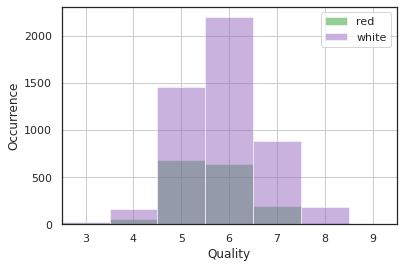

In [8]:
# seaborn styles
sns.set_context('notebook')
sns.set_style('white')

# custom colors
red = sns.color_palette()[2]
white = sns.color_palette()[4]

# set bins for histogram
bin_range = np.array([3, 4, 5, 6, 7, 8, 9])

# plot histogram of quality counts for red and white wines
ax = plt.axes()
for color, plot_color in zip(['red', 'white'], [red, white]):
    q_data = data.loc[data.color==color, 'quality']
    q_data.hist(bins=bin_range, 
                alpha=0.5, ax=ax, 
                color=plot_color, label=color)
    

ax.legend()
ax.set(xlabel='Quality', ylabel='Occurrence')

# force tick labels to be in middle of region
ax.set_xlim(3,10)
ax.set_xticks(bin_range+0.5)
ax.set_xticklabels(bin_range);
ax.grid('off')
### END SOLUTION

## Question 2

*   Examine the correlation and skew of the relevant variables--everything except color and quality (without dropping these columns from our data).
*   Perform any appropriate feature transformations and/or scaling.
*   Examine the pairwise distribution of the variables with pairplots to verify scaling and normalization efforts.


In [9]:
### BEGIN SOLUTION
float_columns = [x for x in data.columns if x not in ['color', 'quality']]

# The correlation matrix
corr_mat = data[float_columns].corr()

# Strip out the diagonal values for the next step
for x in range(len(float_columns)):
    corr_mat.iloc[x,x] = 0.0
    
corr_mat

,fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,density,pH,sulphates,alcohol
fixed_acidity,0.000000,0.219008,0.324436,-0.111981,0.298195,-0.282735,-0.329054,0.458910,-0.252700,0.299568,-0.095452
volatile_acidity,0.219008,0.000000,-0.377981,-0.196011,0.377124,-0.352557,-0.414476,0.271296,0.261454,0.225984,-0.037640
citric_acid,0.324436,-0.377981,0.000000,0.142451,0.038998,0.133126,0.195242,0.096154,-0.329808,0.056197,-0.010493
residual_sugar,-0.111981,-0.196011,0.142451,0.000000,-0.128940,0.402871,0.495482,0.552517,-0.267320,-0.185927,-0.359415
chlorides,0.298195,0.377124,0.038998,-0.128940,0.000000,-0.195045,-0.279630,0.362615,0.044708,0.395593,-0.256916
free_sulfur_dioxide,-0.282735,-0.352557,0.133126,0.402871,-0.195045,0.000000,0.720934,0.025717,-0.145854,-0.188457,-0.179838
total_sulfur_dioxide,-0.329054,-0.414476,0.195242,0.495482,-0.279630,0.720934,0.000000,0.032395,-0.238413,-0.275727,-0.265740
density,0.458910,0.271296,0.096154,0.552517,0.362615,0.025717,0.032395,0.000000,0.011686,0.259478,-0.686745
pH,-0.252700,0.261454,-0.329808,-0.267320,0.044708,-0.145854,-0.238413,0.011686,0.000000,0.192123,0.121248
sulphates,0.299568,0.225984,0.056197,-0.185927,0.395593,-0.188457,-0.275727,0.259478,0.192123,0.000000,-0.003029


In [10]:
# Pairwise maximal correlations
corr_mat.abs().idxmax()

fixed_acidity                        density
volatile_acidity        total_sulfur_dioxide
citric_acid                 volatile_acidity
residual_sugar                       density
chlorides                          sulphates
free_sulfur_dioxide     total_sulfur_dioxide
total_sulfur_dioxide     free_sulfur_dioxide
density                              alcohol
pH                               citric_acid
sulphates                          chlorides
alcohol                              density
dtype: object

And an examination of the skew values in anticipation of transformations.


In [11]:
skew_columns = (data[float_columns]
                .skew()
                .sort_values(ascending=False))

skew_columns = skew_columns.loc[skew_columns > 0.75]
skew_columns

chlorides              5.399828
sulphates              1.797270
fixed_acidity          1.723290
volatile_acidity       1.495097
residual_sugar         1.435404
free_sulfur_dioxide    1.220066
dtype: float64

In [12]:
# Perform log transform on skewed columns
for col in skew_columns.index.tolist():
    data[col] = np.log1p(data[col])


Perform feature scaling.


In [13]:
from sklearn.preprocessing import StandardScaler

sc = StandardScaler()
data[float_columns] = sc.fit_transform(data[float_columns])

data.head(4)

,fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,density,pH,sulphates,alcohol,quality,color
0,0.229509,2.135767,-2.192833,-0.815173,0.624554,-1.193601,-1.446359,1.034993,1.813090,0.250355,-0.915464,5,red
1,0.550261,3.012817,-2.192833,-0.498175,1.281999,-0.013944,-0.862469,0.701486,-0.115073,1.059213,-0.580068,5,red
2,0.550261,2.438032,-1.917553,-0.625740,1.104012,-0.754684,-1.092486,0.768188,0.258120,0.862549,-0.580068,5,red
3,2.802728,-0.337109,1.661085,-0.815173,0.594352,-0.574982,-0.986324,1.101694,-0.363868,0.389396,-0.580068,6,red


Finally, the pairplot of the transformed and scaled features.


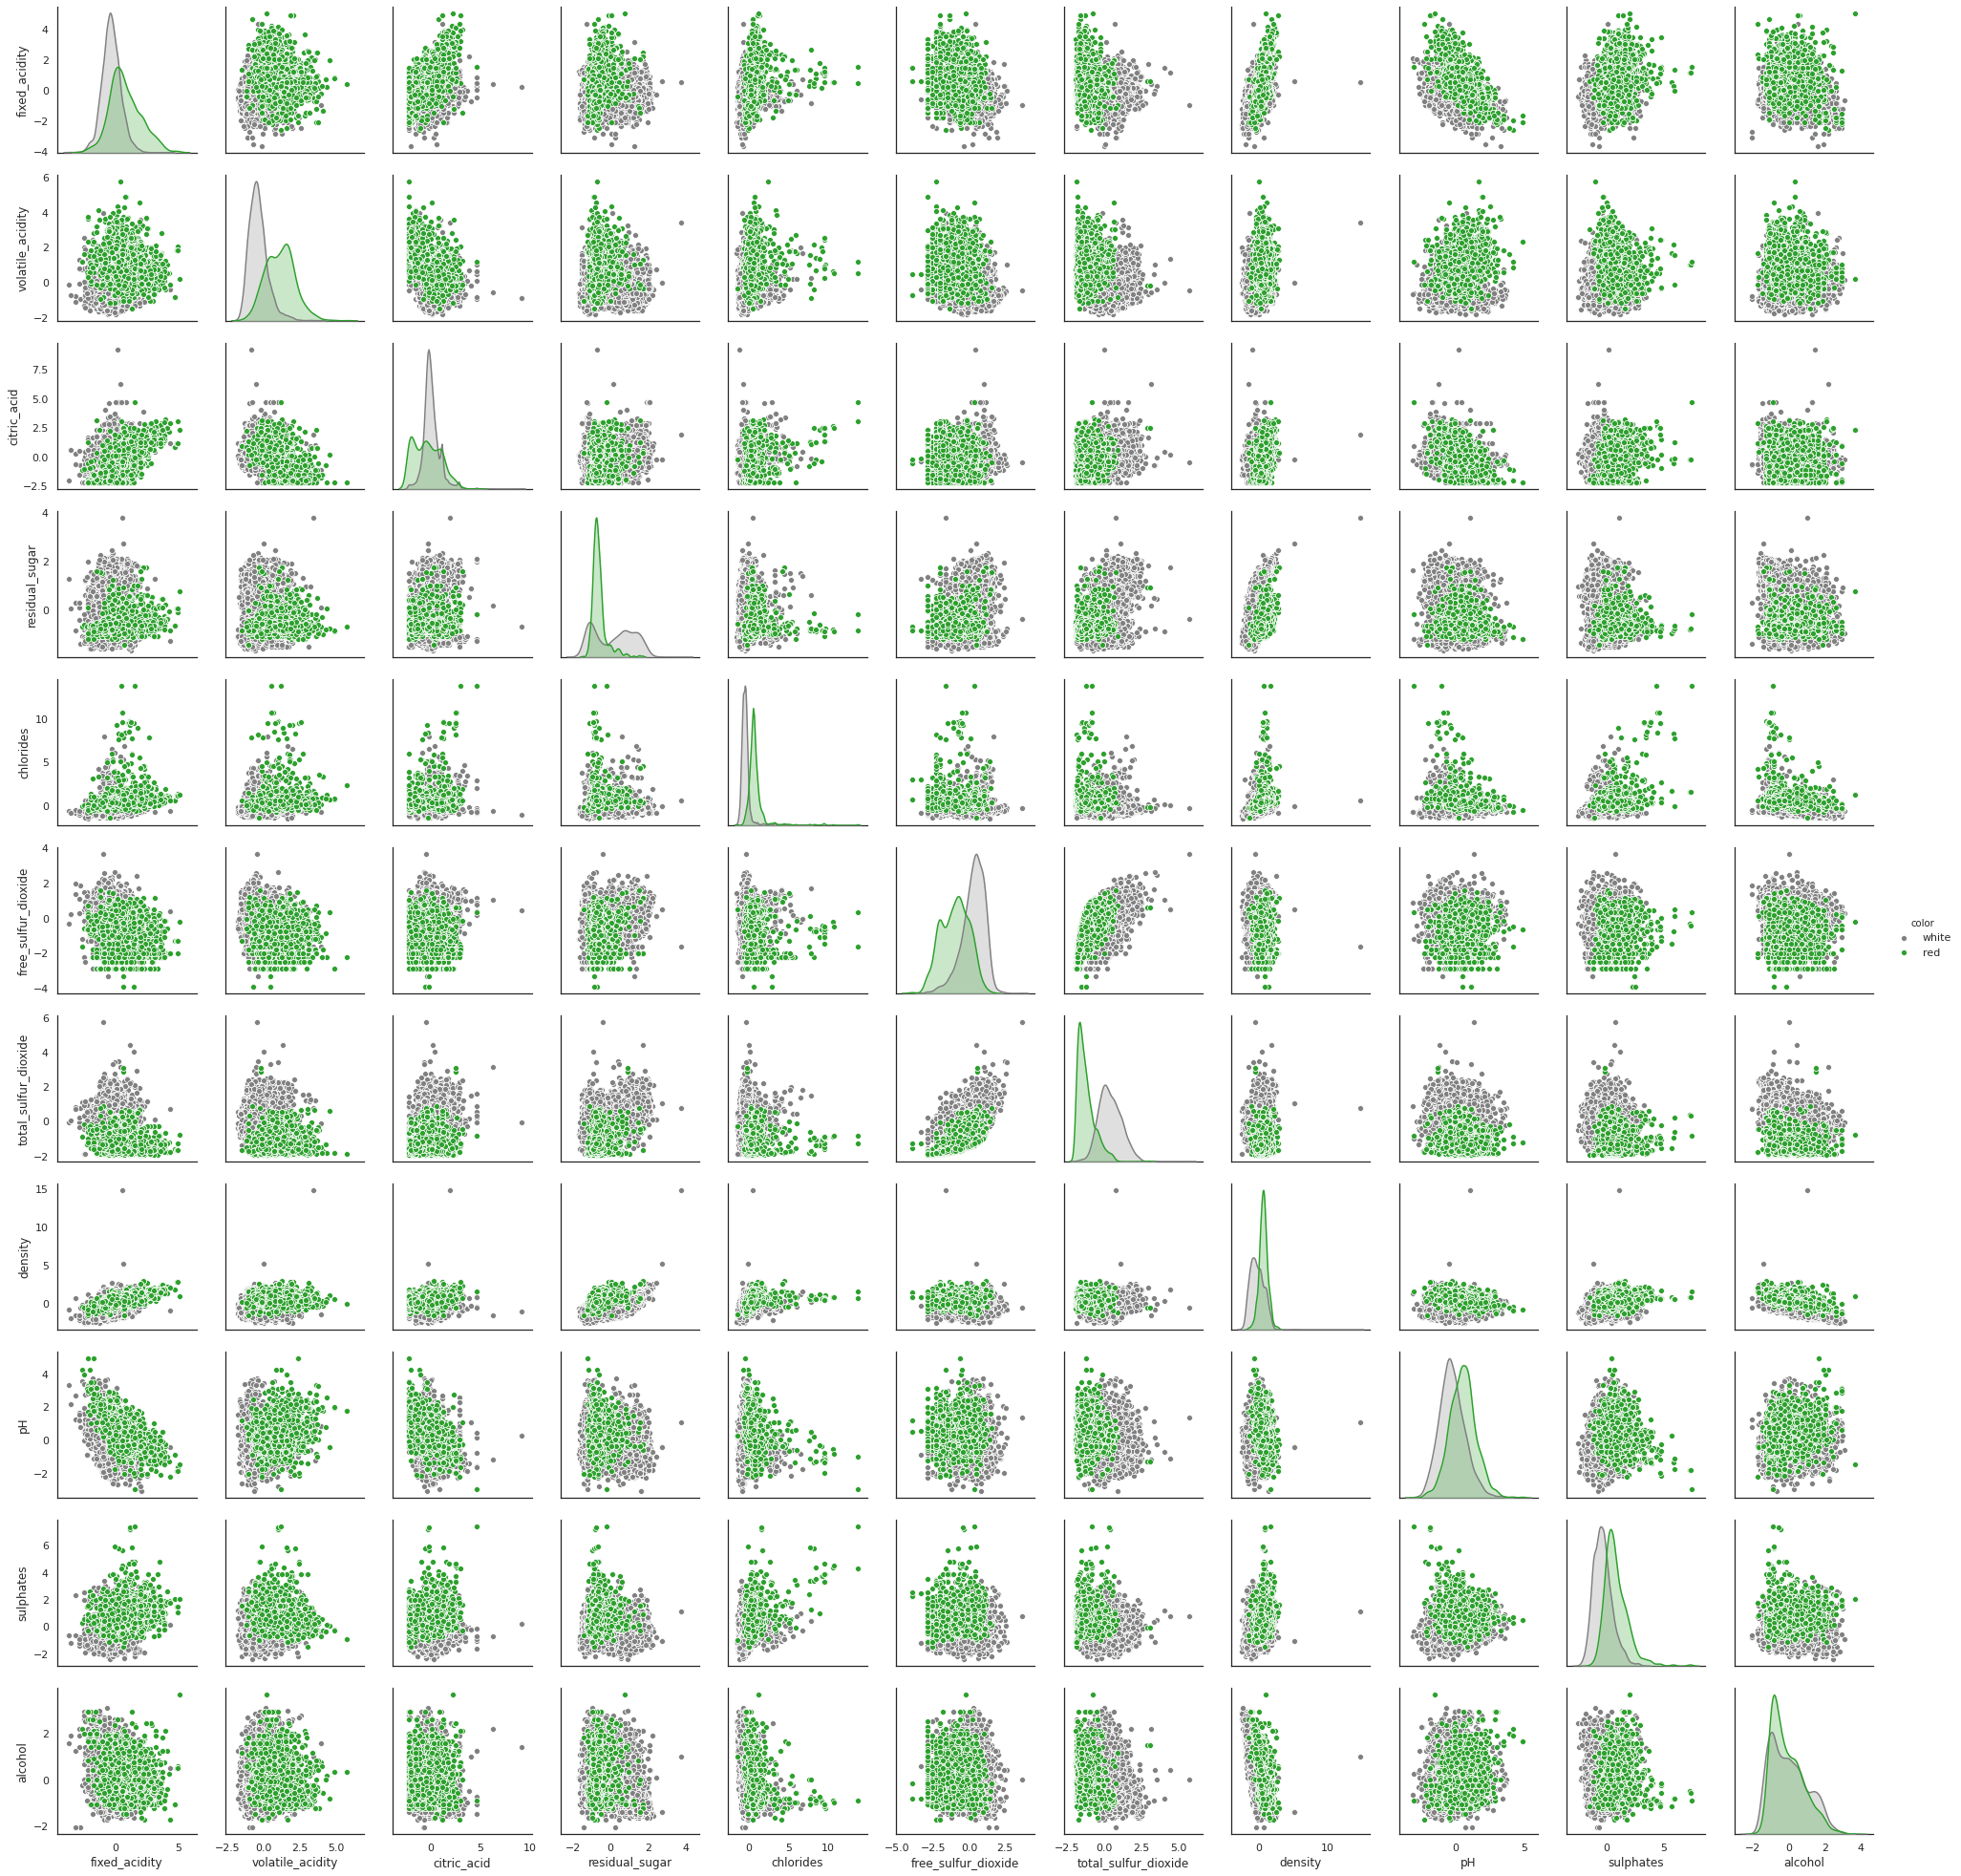

In [14]:
sns.set_context('notebook')
sns.pairplot(data[float_columns + ['color']], 
             hue='color', 
             hue_order=['white', 'red'],
             palette={'red':red, 'white':'gray'});
### END SOLUTION

## Question 3

*   Fit a K-means clustering model with two clusters.
*   Examine the clusters by counting the number of red and white wines in each cluster.


In [15]:
from sklearn.cluster import KMeans
### BEGIN SOLUTION
km = KMeans(n_clusters=2, random_state=42)
km = km.fit(data[float_columns])

data['kmeans'] = km.predict(data[float_columns])

In [16]:
(data[['color','kmeans']]
 .groupby(['kmeans','color'])
 .size()
 .to_frame()
 .rename(columns={0:'number'}))
### END SOLUTION

number
kmeans color        
0      red      1576
       white      87
1      red        23
       white    4811

## Question 4

*   Now fit K-Means models with cluster values ranging from 1 to 20.
*   For each model, store the number of clusters and the inertia value.
*   Plot cluster number vs inertia. Does there appear to be an ideal cluster number?


In [17]:
### BEGIN SOLUTION
# Create and fit a range of models
km_list = list()

for clust in range(1,21):
    km = KMeans(n_clusters=clust, random_state=42)
    km = km.fit(data[float_columns])
    
    km_list.append(pd.Series({'clusters': clust, 
                              'inertia': km.inertia_,
                              'model': km}))

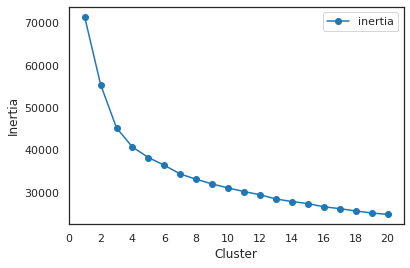

In [18]:
plot_data = (pd.concat(km_list, axis=1)
             .T
             [['clusters','inertia']]
             .set_index('clusters'))

ax = plot_data.plot(marker='o',ls='-')
ax.set_xticks(range(0,21,2))
ax.set_xlim(0,21)
ax.set(xlabel='Cluster', ylabel='Inertia');
### END SOLUTION

## Question 5

*   Fit an agglomerative clustering model with two clusters.
*   Compare the results to those obtained by K-means with regards to wine color by reporting the number of red and white observations in each cluster for both K-means and agglomerative clustering.
*   Visualize the dendrogram produced by agglomerative clustering. *Hint:* SciPy has a module called [`cluster.hierarchy`](https://docs.scipy.org/doc/scipy/reference/cluster.hierarchy.html?utm_medium=Exinfluencer&utm_source=Exinfluencer&utm_content=000026UJ&utm_term=10006555&utm_id=NA-SkillsNetwork-Channel-SkillsNetworkCoursesIBMML0187ENSkillsNetwork31430127-2022-01-01#module-scipy.cluster.hierarchy) that contains the `linkage` and `dendrogram` functions required to create the linkage map and plot the resulting dendrogram.


In [19]:
from sklearn.cluster import AgglomerativeClustering
### BEGIN SOLUTION
ag = AgglomerativeClustering(n_clusters=2, linkage='ward', compute_full_tree=True)
ag = ag.fit(data[float_columns])
data['agglom'] = ag.fit_predict(data[float_columns])

Note that cluster assignment is arbitrary, the respective primary cluster numbers for red and white may not be identical to the ones below and also may not be the same for both K-means and agglomerative clustering.


In [20]:
# First, for Agglomerative Clustering:
(data[['color','agglom','kmeans']]
 .groupby(['color','agglom'])
 .size()
 .to_frame()
 .rename(columns={0:'number'}))

number
color agglom        
red   0           31
      1         1568
white 0         4755
      1          143

In [21]:
# Comparing with KMeans results:
(data[['color','agglom','kmeans']]
 .groupby(['color','kmeans'])
 .size()
 .to_frame()
 .rename(columns={0:'number'}))

number
color kmeans        
red   0         1576
      1           23
white 0           87
      1         4811

In [22]:
# Comparing results:
(data[['color','agglom','kmeans']]
 .groupby(['color','agglom','kmeans'])
 .size()
 .to_frame()
 .rename(columns={0:'number'}))

number
color agglom kmeans        
red   0      0           13
             1           18
      1      0         1563
             1            5
white 0      0           38
             1         4717
      1      0           49
             1           94

Though the cluster numbers are not identical, the clusters are very consistent within a single wine variety (red or white).

And here is a plot of the dendrogram created from agglomerative clustering.


NameError: name 'colors' is not defined

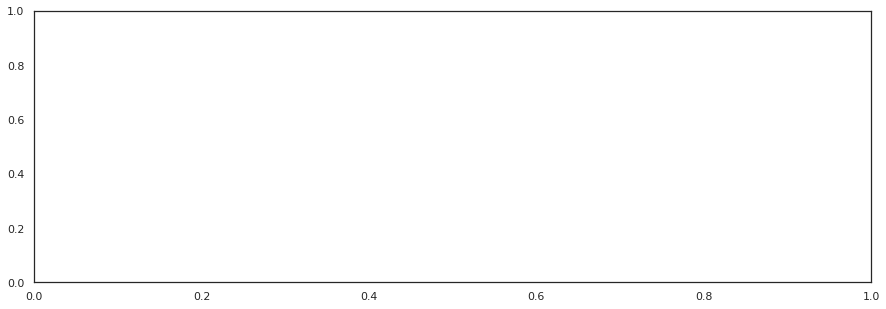

In [23]:
# First, we import the cluster hierarchy module from SciPy (described above) to obtain the linkage and dendrogram functions.
from scipy.cluster import hierarchy

Z = hierarchy.linkage(ag.children_, method='ward')

fig, ax = plt.subplots(figsize=(15,5))

# Some color setup
red = colors[2]
blue = colors[0]

hierarchy.set_link_color_palette([red, 'gray'])

den = hierarchy.dendrogram(Z, orientation='top', 
                           p=30, truncate_mode='lastp',
                           show_leaf_counts=True, ax=ax,
                           above_threshold_color=blue)
### END SOLUTION

## Question 6

In this question, we are going to explore clustering as a form of feature engineering.

*   Create a **binary** target variable `y`, denoting if the quality is greater than 7 or not.
*   Create a variable called `X_with_kmeans` from `data`, by dropping the columns "quality", "color" and "agglom" from the dataset. Create `X_without_kmeans` from that by dropping "kmeans".
*   For both datasets, using **[StratifiedShuffleSplit](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.StratifiedShuffleSplit.html?utm_medium=Exinfluencer&utm_source=Exinfluencer&utm_content=000026UJ&utm_term=10006555&utm_id=NA-SkillsNetwork-Channel-SkillsNetworkCoursesIBMML0187ENSkillsNetwork31430127-2022-01-01)** with 10 splits, fit 10 Random Forest Classifiers and find the mean of the ROC-AUC scores from these 10 classifiers.
*   Compare the average roc-auc scores for both models, the one using the KMeans cluster as a feature and the one that doesn't use it.


In [24]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, roc_auc_score
from sklearn.model_selection import StratifiedShuffleSplit

### BEGIN SOLUTION
y = (data['quality'] > 7).astype(int)
X_with_kmeans = data.drop(['agglom', 'color', 'quality'], axis=1)
X_without_kmeans = X_with_kmeans.drop('kmeans', axis=1)
sss = StratifiedShuffleSplit(n_splits=10, random_state=6532)

def get_avg_roc_10splits(estimator, X, y):
    roc_auc_list = []
    for train_index, test_index in sss.split(X, y):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        estimator.fit(X_train, y_train)
        y_predicted = estimator.predict(X_test)
        y_scored = estimator.predict_proba(X_test)[:, 1]
        roc_auc_list.append(roc_auc_score(y_test, y_scored))
    return np.mean(roc_auc_list)
# return classification_report(y_test, y_predicted)

estimator = RandomForestClassifier()
roc_with_kmeans = get_avg_roc_10splits(estimator, X_with_kmeans, y)
roc_without_kmeans = get_avg_roc_10splits(estimator, X_without_kmeans, y)
print("Without kmeans cluster as input to Random Forest, roc-auc is \"{0}\"".format(roc_without_kmeans))
print("Using kmeans cluster as input to Random Forest, roc-auc is \"{0}\"".format(roc_with_kmeans))

Without kmeans cluster as input to Random Forest, roc-auc is "0.841734126984127"
Using kmeans cluster as input to Random Forest, roc-auc is "0.8392460317460317"


Let's now explore if the number of clusters have an effect in this improvement.

*   Create the basis training set from `data` by restricting to float_columns.
*   For $n = 1, \ldots, 20$, fit a KMeans algorithim with $n$ clusters. **[One-hot encode]()** it and add it to the **basis** training set. Don't add it to the previous iteration.
*   Fit 10 **Logistic Regression** models and compute the average roc-auc-score.
*   Plot the average roc-auc scores.


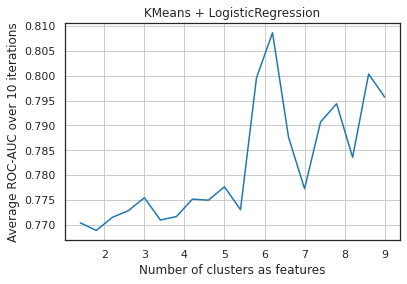

In [25]:
from sklearn.linear_model import LogisticRegression

X_basis = data[float_columns]
sss = StratifiedShuffleSplit(n_splits=10, random_state=6532)

def create_kmeans_columns(n):
    km = KMeans(n_clusters=n)
    km.fit(X_basis)
    km_col = pd.Series(km.predict(X_basis))
    km_cols = pd.get_dummies(km_col, prefix='kmeans_cluster')
    return pd.concat([X_basis, km_cols], axis=1)

estimator = LogisticRegression()
ns = range(1, 21)
roc_auc_list = [get_avg_roc_10splits(estimator, create_kmeans_columns(n), y)
                for n in ns]

ax = plt.axes()
ax.plot(ns, roc_auc_list)
ax.set(
    xticklabels= ns,
    xlabel='Number of clusters as features',
    ylabel='Average ROC-AUC over 10 iterations',
    title='KMeans + LogisticRegression'
)
ax.grid(True)
### END SOLUTION

***

### Machine Learning Foundation (C) 2020 IBM Corporation
